In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe
import pygmt
from scipy.stats import wilcoxon
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import mannwhitneyu
from xarray import DataArray
from scipy.ndimage import gaussian_filter
from numpy import deg2rad, sin, cos, meshgrid, gradient

In [2]:
def regridding1(carbdata):
    ds_in = xr.DataArray(
        dims=["latitude", "longitude"],
        coords={"latitude": np.arange(-90,90.05,0.05), "longitude": np.arange(-180,180.05,0.05)},
    )
    ds_out = xe.util.grid_2d(-180.0, 180.0, 0.1, -90.0, 90.0, 0.1)
    regrid = xe.Regridder(ds_in, ds_out, 'nearest_s2d', periodic=True, weights='../paleo_reef/data/nearest_s2d_gridder_res1.nc')
    return regrid(carbdata)

def regridding2(ds):
    ds_out = xe.util.grid_2d(-180.0, 180.0, 0.25, -90.0, 90.0, 0.25)
    regrid = xe.Regridder(ds, ds_out, 'nearest_s2d', periodic=True, weights='../paleo_reef/data/nearest_s2d_gridder_res2.nc')
    return regrid(ds)

def getData(timeclim, CO2curve='smooth'):
    abiotic = xr.open_dataset('../paleo_reef/env_var/enviVar'+str(timeclim)+'Ma_res1_'+CO2curve+'.nc')
    continent = abiotic.flood.fillna(10)
    continent = continent.where(continent>4)
    abiotic['elevation'] = abiotic.bathy.copy()
    shelf = xr.open_dataset('../paleo_reef/data/shelfs/'+str(timeclim)+'Ma.nc')
    shelf2 = regridding1(shelf)
    shelf.close()
    abiotic['shelf'] = (('latitude', 'longitude'), shelf2.flood.values)
    ensemble = xr.open_dataset('../paleoReef/photozoan.res2/proj_'+str(timeclim)+'Ma/proj_'+str(timeclim)+'Ma_photozoan.res2_ensemble.tif')
    return abiotic, ensemble, continent

def earth_radius(lat):
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )
    return r

def area_grid(lat, lon):
    xlon, ylat = meshgrid(lon, lat)
    R = earth_radius(ylat)
    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))
    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))
    area = dy * dx
    xda = DataArray(
        area,
        dims=["latitude", "longitude"],
        coords={"latitude": lat, "longitude": lon},
        attrs={
            "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
        },
    )
    return xda

In [3]:
eons = pd.read_csv('data/stage_bins.csv')
bins = np.round(eons['mid_ma'].values,3)
inter_name = eons['interval_name'].values
stage_max_ma = eons['max_ma'].values
stage_min_ma = eons['min_ma'].values

In [4]:
PARED = pd.read_csv('data/occurrences/PARED_06_10_2021.csv')
PARED = PARED[['r_number','intervall', 'max_ma', 'min_ma' ,
       'latit', 'longit', 'pal_lat_scotese',
       'pal_long_scotese','tropical_text','environment_text',
       'subenvironment_text','biota_main_t', 'biota_sec_text', 'biota_deta_text',
       'alg_type_text']]

r_number = PARED['r_number'].values.copy()

# Limit date of occurence later than 270 Ma
PARED = PARED[PARED['min_ma']<270].reset_index(drop=True)

# Limit date of occurence earlier than 3 Ma
PARED = PARED[PARED['min_ma']>3].reset_index(drop=True)

# Remove data without associated biota description
mask = (PARED['biota_main_t'].notnull()).values
PARED = PARED[mask]

# Remove data without associated environment description
mask = (PARED['environment_text'].notnull()).values
PARED = PARED[mask]

# Remove data with associated environment description set to basin (assuming basins are deep carbonates)
mask = (PARED['environment_text'] != 'Basin').values
PARED = PARED[mask]

# Remove data which are in cold water as we look at photozoan factory
mask = (PARED['tropical_text'] != 'Cold - water').values
PARED = PARED[mask]

# Remove data which are in temperate regions as we look at photozoan factory
mask = (PARED['tropical_text'] != 'Temperate').values
PARED = PARED[mask]

# Remove data which are named as deeper slope or outer ramp
mask = (PARED['subenvironment_text'] != 'Deeper slope or outer ramp').values
PARED = PARED[mask]

# Remove biota which are not associated to photozoan
mask = (PARED['biota_main_t'] != 'Bryozoans').values
PARED = PARED[mask]

mask = (PARED['biota_main_t'] != 'Brachiopods').values
PARED = PARED[mask]

mask = (PARED['biota_main_t'] != 'Microbes').values
PARED = PARED[mask]

# Remove tropical column and algae type column as they are not needed anymore
PARED = PARED.drop(columns=['tropical_text','subenvironment_text',
                            'alg_type_text','environment_text',
                            'biota_main_t','biota_sec_text',
                            'biota_deta_text'], axis=1).reset_index(drop=True)

In [5]:
PARED

,r_number,intervall,max_ma,min_ma,latit,longit,pal_lat_scotese,pal_long_scotese
0,1203,Aptian-Cenomanian,125.0,93.9,19.2333,-179.5500,-18.0054,-145.159
1,1215,Aptian,125.0,113.0,19.2333,-179.5500,-19.7438,-144.882
2,1264,Barremian-Aptian,129.4,113.0,18.5333,-179.5500,-21.4245,-144.928
3,1265,Albian,113.0,100.5,18.5333,-179.5500,-16.3517,-143.134
4,713,Miocene,23.0,5.3,28.2333,-177.4000,22.3335,-163.921
...,...,...,...,...,...,...,...,...
1587,1262,Barremian-Aptian,129.4,113.0,21.1333,174.3833,-18.0427,-150.827
1588,1263,Albian,113.0,100.5,21.1333,174.3833,-13.1310,-148.638
1589,3155,early Early Miocene,23.0,20.4,-17.9333,177.3333,-36.6321,-179.387
1590,3156,Early/Middle Miocene,23.0,11.6,-17.9333,177.3333,-34.0689,179.979


In [6]:
def assign_bins_prob(PARED, k , bins):
    
    tmin = PARED['min_ma'][k]
    tmax = PARED['max_ma'][k]
    gen = np.linspace(tmin, tmax, num=10000)
    hist = np.histogram(gen, bins=bins)
    idmax = np.argmax(hist[0])
    mid_ma = hist[1][idmax]
    prob = hist[0][idmax]/10000

    return mid_ma, prob

In [7]:
mid_ma = []
prob = []
for k in range(len(PARED)):
    age, p = assign_bins_prob(PARED,k , bins)
    mid_ma.append(age)
    prob.append(p)
    
PARED['mid_ma'] = mid_ma
PARED['prob'] = prob
PARED = PARED[PARED.prob>=0.5].reset_index(drop=True).drop(columns=['min_ma','max_ma'])
pmax = []
pmin = []
pname = []
for k in range(len(PARED)):
    pared_mid_ma = PARED['mid_ma'].values[k]
    sid = np.where(pared_mid_ma==bins)[0]
    pname.append(inter_name[sid][0])
    pmax.append(stage_max_ma[sid][0])
    pmin.append(stage_min_ma[sid][0])
    
PARED['interval_name'] = pname
PARED['max_ma'] = pmax
PARED['min_ma'] = pmin
PARED = PARED.drop(columns=['intervall','prob'])

In [8]:
len(PARED)

1306

In [9]:
PARED.groupby('mid_ma').count() #['r_number'].plot()

,r_number,latit,longit,pal_lat_scotese,pal_long_scotese,interval_name,max_ma,min_ma
mid_ma,,,,,,,,
3.094,4,4,4,4,4,4,4,4
6.290,32,32,32,32,32,32,32,32
9.433,34,34,34,34,34,34,34,34
12.720,2,2,2,2,2,2,2,2
14.895,56,56,56,56,56,56,56,56
18.205,71,71,71,71,71,71,71,71
21.735,31,31,31,31,31,31,31,31
25.565,24,24,24,24,24,24,24,24
31.000,18,18,18,18,18,18,18,18


In [10]:
# occ_reef = pd.read_csv('reef_occurrences_time_tristan.csv')
# occ_reef = occ_reef.sort_values(by=['mid_ma']).reset_index().drop(columns=['index'])
# occ_reef

In [11]:
timedata = pd.read_csv('bristol_sim_list.csv')
timedata = timedata.sort_values(by=['time'])
tmid = timedata['time'].values.copy()
tmin = tmid[1:]-(tmid[1:]-tmid[:-1])/2
tmax = tmid[:-1]+(tmid[1:]-tmid[:-1])/2
ntmin = np.zeros(len(tmid))
ntmax = np.zeros(len(tmid))
ntmin[1:] = tmin
ntmax[:-1] = tmax
ntmax[-1] = 270
timedata['min'] = ntmin
timedata['max'] = ntmax
timedata

,model,time,name,min,max
53,texpa1,0,0Ma,0.0,2.0
52,texpb,4,3Ma,2.0,7.0
51,texpc,10,11Ma,7.0,12.0
50,texpd,14,15Ma,12.0,16.5
49,texpe,19,20Ma,16.5,22.0
48,texpf,25,26Ma,22.0,28.0
47,texpg11,31,31Ma,28.0,33.0
46,texph1,35,36Ma,33.0,37.0
45,texpi11,39,40Ma,37.0,41.5
44,texpj2,44,45Ma,41.5,48.0


In [12]:
mid_ma = PARED['mid_ma'].unique()

In [13]:
simt = []
for p in range(len(mid_ma)):
    val = timedata.loc[(timedata['min']<=mid_ma[p]) & 
                 (timedata['max']>mid_ma[p])]['time'].values
    simt.append(val[0])

In [14]:
valt = np.zeros(len(PARED))
for p in range(len(mid_ma)):
    valt[PARED.loc[(PARED['mid_ma']==mid_ma[p])].index] = simt[p]
PARED['simt'] = valt

In [15]:
PARED = PARED[PARED['pal_lat_scotese'].notnull()]
PARED = PARED[PARED['pal_long_scotese'].notnull()]

<Axes: xlabel='simt'>

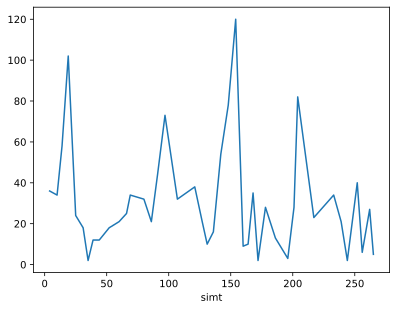

In [16]:
PARED.groupby('simt').count()['r_number'].plot()

In [17]:
reeflat = PARED['pal_lat_scotese'].values.copy()
reeflon = PARED['pal_long_scotese'].values.copy()
reefsimt = PARED['simt'].values.copy()
uniquetime = PARED['simt'].unique()

In [18]:
tosave = []
for p in range(len(uniquetime)):
    ds = xr.open_dataset('../paleo_reef/env_var/enviVar'+str(int(uniquetime[p]))+'Ma_res1_foster.nc')
    ids = np.where(reefsimt==uniquetime[p])[0]
    keepID = []
    removeID = []
    for k in range(len(ids)):
        bathy = ds.sel(latitude=reeflat[k],longitude=reeflon[k],method='nearest').bathy.values+0.
        flood = ds.sel(latitude=reeflat[k],longitude=reeflon[k],method='nearest').flood.values+0.
        if flood == 1 or bathy < 0:
            keepID.append(k)
        else:
            removeID.append(k)
    tosave.append(ids[keepID])

In [19]:
combIDs = np.concatenate((tosave[0],tosave[1]))
for k in range(2,len(tosave)):
    combIDs = np.concatenate((combIDs,tosave[k]))
    
# combIDs2 = np.concatenate((tosave2[0],tosave2[1]))
# for k in range(2,len(tosave2)):
#     combIDs2 = np.concatenate((combIDs2,tosave2[k]))

In [20]:
cleanDF = PARED.iloc[combIDs].reset_index().drop(columns=['index'])

In [21]:
cleanDF.groupby('simt').count() #['r_number'].values

,r_number,latit,longit,pal_lat_scotese,pal_long_scotese,mid_ma,interval_name,max_ma,min_ma
simt,,,,,,,,,
4.0,31,31,31,31,31,31,31,31,31
10.0,29,29,29,29,29,29,29,29,29
14.0,52,52,52,52,52,52,52,52,52
19.0,93,93,93,93,93,93,93,93,93
25.0,21,21,21,21,21,21,21,21,21
31.0,18,18,18,18,18,18,18,18,18
35.0,2,2,2,2,2,2,2,2,2
39.0,12,12,12,12,12,12,12,12,12
44.0,12,12,12,12,12,12,12,12,12


In [22]:
cleanDF.groupby('simt').count() #['r_number'].plot()
# cleanDF2.groupby('simt').count()['r_number'].plot()

,r_number,latit,longit,pal_lat_scotese,pal_long_scotese,mid_ma,interval_name,max_ma,min_ma
simt,,,,,,,,,
4.0,31,31,31,31,31,31,31,31,31
10.0,29,29,29,29,29,29,29,29,29
14.0,52,52,52,52,52,52,52,52,52
19.0,93,93,93,93,93,93,93,93,93
25.0,21,21,21,21,21,21,21,21,21
31.0,18,18,18,18,18,18,18,18,18
35.0,2,2,2,2,2,2,2,2,2
39.0,12,12,12,12,12,12,12,12,12
44.0,12,12,12,12,12,12,12,12,12


In [23]:
occ_count = []
reefsimt2 = cleanDF['simt'].values.copy()
for p in range(len(uniquetime)):
    occ_count.append(len(np.where(reefsimt2==uniquetime[p])[0]))

In [24]:
def myround(x, base=5):
    return base * round(x/base)

nsimt = cleanDF.groupby('simt').count().index

simt5 = np.zeros(len(nsimt))
for k in range(len(nsimt)):
    simt5[k] = myround(nsimt[k])

In [25]:
data = {
    "simt": cleanDF.groupby('simt').count().index.astype('int'),
    "scot": simt5.astype('int'),
    "count": cleanDF.groupby('simt').count()['r_number'].values,
    }
occ_df = pd.DataFrame(data)

In [26]:
# tosave3 = []
# timeround5 = 5*np.round(uniquetime / 5.0)
# for p in range(len(timeround5)):
#     ds = xr.open_dataset('../paleo_reef/sims/wmean_foster/'+str(int(timeround5[p]))+'Ma.nc')
#     ids = np.where(reefsimt==uniquetime[p])[0]
#     keepID = []
#     removeID = []
#     for k in range(len(ids)):
#         wmean = ds.sel(latitude=reeflat[k],longitude=reeflon[k],method='nearest').wmean.values+0.
#         print(wmean)

In [27]:
# ds = xr.open_dataset('../paleo_reef/sims/wmean_foster/95Ma.nc')
# ds

In [28]:
cleanDF.to_csv('data/cleanFossilRecords.csv',index=False)

In [29]:
range_deg = 1.
    
vmean = []
vstd = []
vperc = []

for k in range(len(occ_df)):
    time = occ_df['simt'].iloc[k]
    latsco = cleanDF[cleanDF['simt']==time]['pal_lat_scotese'].values
    lonsco = cleanDF[cleanDF['simt']==time]['pal_long_scotese'].values
    time2 = occ_df['scot'].iloc[k]
    ds = xr.open_dataset('../paleo_reef/sims/wmean_foster/'+str(time2)+'Ma.nc')
    
    position = np.zeros((len(latsco),2))
    position[:,0] = latsco
    position[:,1] = lonsco

    vvv = []
    for k in range(len(latsco)):
        val = ds.sel(latitude=slice(latsco[k]-range_deg,latsco[k]+range_deg),
          longitude=slice(lonsco[k]-range_deg,lonsco[k]+range_deg)).wmean.max().data+0.
        vvv.append(val)
    vvv = np.asarray(vvv)
    nonans = ~np.isnan(vvv)
    vmean.append(vvv[nonans].mean())
    vstd.append(vvv[nonans].std())
    vperc.append(len(vvv[nonans])*100/len(vvv))
    
occ_df['mean'] = vmean
occ_df['std'] = vstd
occ_df['perc'] = vperc
occ_df

,simt,scot,count,mean,std,perc
0,4,5,31,227.651410,341.967392,87.096774
1,10,10,29,344.918147,328.612057,100.000000
2,14,15,52,370.205935,354.235629,96.153846
3,19,20,93,502.482636,313.772168,86.021505
4,25,25,21,512.972143,319.655420,57.142857
5,31,30,18,315.788995,286.479607,88.888889
6,35,35,2,191.787571,87.129421,100.000000
7,39,40,12,342.588287,178.922390,75.000000
8,44,45,12,306.054878,131.366374,91.666667
9,52,50,18,512.144241,209.632593,66.666667


In [30]:
occ_df.to_csv('data/occurrences.csv',index=False)

In [31]:
occ_df['perc'].mean(),occ_df['mean'].mean()

(85.84431880917735, 509.74523083618755)

In [32]:
occ_df['perc'].mean(),occ_df['mean'].mean()

(85.84431880917735, 509.74523083618755)

In [33]:
occ_df['perc'].mean(),occ_df['mean'].mean()

(85.84431880917735, 509.74523083618755)

In [34]:
occ_df

,simt,scot,count,mean,std,perc
0,4,5,31,227.651410,341.967392,87.096774
1,10,10,29,344.918147,328.612057,100.000000
2,14,15,52,370.205935,354.235629,96.153846
3,19,20,93,502.482636,313.772168,86.021505
4,25,25,21,512.972143,319.655420,57.142857
5,31,30,18,315.788995,286.479607,88.888889
6,35,35,2,191.787571,87.129421,100.000000
7,39,40,12,342.588287,178.922390,75.000000
8,44,45,12,306.054878,131.366374,91.666667
9,52,50,18,512.144241,209.632593,66.666667


In [ ]:
timeclim = 4
curve = 'foster'
range_deg = 1.
    
vmean = []
vstd = []
vperc = []

for t in range(len(occ_df)):
    timeclim = occ_df['simt'].iloc[t]
    abiotic, ensemble, continent = getData(timeclim, CO2curve=curve)
    flooddata = regridding2(abiotic)
    da_area = area_grid(abiotic['latitude'], abiotic['longitude'])

    dataType = ['e_mean','cv','e_median','ca','wmean','ciInf', 'ciSup']

    dataName = ['Mean', 'Coefficient of variation', 'Median', 
                'Committee averaging score', 'Weighted mean', 
                'Confidence interval (lower)', 'Confidence interval (upper)']
    nda = xr.DataArray(
                        ensemble.isel(band=4).band_data.values,
                        dims=["latitude", "longitude"],
                        coords={"latitude": ensemble.y.values, "longitude": ensemble.x.values},
                    )
    dataEM = nda.to_dataset(name=dataType[4])
    tmp = nda.fillna(0).values
    dataEM[dataType[4]] = (('latitude', 'longitude'), gaussian_filter(tmp,1))
    dataEM['flood'] = (('latitude', 'longitude'), np.flipud(flooddata.flood.values))
    dataEMFlood = dataEM.where(dataEM.flood==1)
    latsco = cleanDF[cleanDF['simt']==timeclim]['pal_lat_scotese'].values
    lonsco = cleanDF[cleanDF['simt']==timeclim]['pal_long_scotese'].values
    time2 = occ_df['scot'].iloc[t]
    position = np.zeros((len(latsco),2))
    position[:,0] = latsco
    position[:,1] = lonsco
    vvv = []
    for k in range(len(latsco)):
        val = dataEMFlood.sel(latitude=slice(latsco[k]+range_deg,latsco[k]-range_deg),
          longitude=slice(lonsco[k]-range_deg,lonsco[k]+range_deg)).wmean.max().data+0.
        vvv.append(val)
    vvv = np.asarray(vvv)
    nonans = ~np.isnan(vvv)
    vmean.append(vvv[nonans].mean())
    vstd.append(vvv[nonans].std())
    vperc.append(len(vvv[nonans])*100/len(vvv))

In [ ]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='Predictive performance (%)',
       xlabel='Time (Ma)')
plt.plot(occ_df['simt'], vperc, color = 'r', lw='1', ls='-')
plt.scatter(occ_df['simt'], vperc, s=30,
            marker='o',facecolor='red',lw=0.3,
            edgecolor='black',zorder=2)


plt.plot(occ_df['simt'], occ_df['count'], color = 'k', lw='1', ls='--')
plt.scatter(occ_df['simt'], occ_df['count'], s=30,
            marker='o',facecolor='black',lw=0.3,
            edgecolor='black',zorder=1)

plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
plt.show()

In [ ]:
t = 10
timeclim = occ_df['simt'].iloc[t]
print(timeclim)
abiotic, ensemble, continent = getData(timeclim, CO2curve=curve)
flooddata = regridding2(abiotic)
da_area = area_grid(abiotic['latitude'], abiotic['longitude'])

dataType = ['e_mean','cv','e_median','ca','wmean','ciInf', 'ciSup']

dataName = ['Mean', 'Coefficient of variation', 'Median', 
            'Committee averaging score', 'Weighted mean', 
            'Confidence interval (lower)', 'Confidence interval (upper)']
nda = xr.DataArray(
                    ensemble.isel(band=4).band_data.values,
                    dims=["latitude", "longitude"],
                    coords={"latitude": ensemble.y.values, "longitude": ensemble.x.values},
                )
dataEM = nda.to_dataset(name=dataType[4])
tmp = nda.fillna(0).values
dataEM[dataType[4]] = (('latitude', 'longitude'), gaussian_filter(tmp,1))
dataEM['flood'] = (('latitude', 'longitude'), np.flipud(flooddata.flood.values))
dataEMFlood = dataEM.where(dataEM.flood==1)
latsco = cleanDF[cleanDF['simt']==timeclim]['pal_lat_scotese'].values
lonsco = cleanDF[cleanDF['simt']==timeclim]['pal_long_scotese'].values
time2 = occ_df['scot'].iloc[t]
position = np.zeros((len(latsco),2))
position[:,0] = latsco
position[:,1] = lonsco
vvv = []
for k in range(len(latsco)):
    val = dataEMFlood.sel(latitude=slice(latsco[k]+range_deg,latsco[k]-range_deg),
      longitude=slice(lonsco[k]-range_deg,lonsco[k]+range_deg)).wmean.max().data+0.
    vvv.append(val)
vvv = np.asarray(vvv)
nonans = ~np.isnan(vvv)

region = [-180,180,-80,80]#'d'

# fig = pygmt.Figure()
# pygmt.config(
#     MAP_FRAME_WIDTH="0.5p",
#     MAP_FRAME_TYPE="fancy",
# )
# font = "4p,Helvetica-Bold"

# with pygmt.config(FONT='4p,Helvetica,black'):
#     pygmt.makecpt(cmap="gray", series=[-15000, 4000])
#     fig.basemap(region=region, projection="Q12c", frame='af')
#     fig.grdimage(abiotic.elevation, shading=True, frame=False) 
#     pygmt.makecpt(cmap="panoply", series=[0, 1000], reverse=False)
#     fig.grdimage(dataEMFlood.wmean.where(dataEMFlood.wmean), shading=False, 
#                  nan_transparent=True, frame=False) 
    
#     fig.grdcontour(interval=1,grid=abiotic.shelf,limit=[1.9, 2],pen="0.9p,white")
#     pygmt.makecpt(cmap="black", series=[8, 10])
#     fig.grdimage(continent, shading=True, nan_transparent=True, frame=False)
#     fig.plot(x=lonsco, y=latsco, style="c0.1/0.15c", fill="purple", pen="0.2p,black")
#     fig.plot(x=lonsco[nonans], y=latsco[nonans], style="c0.1/0.15c", fill="green", pen="0.2p,black")
    
# fig.show(dpi=500, width=1000)

In [ ]:
bins = np.linspace(0, 1000, 21)

In [ ]:
regrid = xe.Regridder(dataEMFlood, abiotic, 'bilinear', periodic=True, weights='../paleo_reef/data/bilinear_gridder_reef.nc') 
ensembleReef = regrid(dataEMFlood)

In [ ]:
step = 10
timeclim = occ_df['simt'].iloc[step]
time2 = occ_df['scot'].iloc[step]
print(timeclim)
abiotic, ensemble, continent = getData(timeclim, CO2curve=curve)
flooddata = regridding2(abiotic)
da_area = area_grid(abiotic['latitude'], abiotic['longitude'])

dataType = ['e_mean','cv','e_median','ca','wmean','ciInf', 'ciSup']

dataName = ['Mean', 'Coefficient of variation', 'Median', 
            'Committee averaging score', 'Weighted mean', 
            'Confidence interval (lower)', 'Confidence interval (upper)']
nda = xr.DataArray(
                    ensemble.isel(band=4).band_data.values,
                    dims=["latitude", "longitude"],
                    coords={"latitude": ensemble.y.values, "longitude": ensemble.x.values},
                )
dataEM = nda.to_dataset(name=dataType[4])
tmp = nda.fillna(0).values
dataEM[dataType[4]] = (('latitude', 'longitude'), gaussian_filter(tmp,1))
dataEM['flood'] = (('latitude', 'longitude'), np.flipud(flooddata.flood.values))
dataEMFlood = dataEM.where(dataEM.flood==1)
latsco = cleanDF[cleanDF['simt']==timeclim]['pal_lat_scotese'].values
lonsco = cleanDF[cleanDF['simt']==timeclim]['pal_long_scotese'].values
position = np.zeros((len(latsco),2))
position[:,0] = latsco
position[:,1] = lonsco
vvv = []
for k in range(len(latsco)):
    val = dataEMFlood.sel(latitude=slice(latsco[k]+range_deg,latsco[k]-range_deg),
      longitude=slice(lonsco[k]-range_deg,lonsco[k]+range_deg)).wmean.max().data+0.
    vvv.append(val)
vvv = np.asarray(vvv)
nonans = ~np.isnan(vvv)

vals = dataEMFlood.wmean.values.flatten().copy()
randpts = vals[~np.isnan(vals)]
randpts = np.random.choice(randpts, size=1000)

med_rand = np.median(randpts)
res = mannwhitneyu(vvv[nonans],randpts,alternative='greater')

In [ ]:
vals2 = dataEMFlood.wmean.values.flatten().copy()
vals2 = vals2[~np.isnan(vals2)]

In [ ]:
vvv[nonans]

In [ ]:

res = mannwhitneyu(vvv[nonans],randpts,alternative='greater') #,zero_method='wilcox')
res

In [ ]:
font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 9,
        }

f, ax = plt.subplots(figsize=(5, 4))

# valhist = (da_area/da_area.max()).data*ensembleReef.wmean
dataEMFlood.wmean.plot.hist(bins=np.linspace(0, 1000, 21),color='lightgray',
                            edgecolor='black', linewidth=1)

ax.set(xlabel='Habitat suitability',
       ylabel='Frequency')
plt.ylim(-1e4, 1e5)

plt.axvline(x = np.median(vvv[nonans]), color = 'r', lw='1.2', ls='--')
plt.scatter(np.median(vvv[nonans]),0,s=40,marker='D',facecolor='red',edgecolor='black')

plt.axvline(x = med_rand, color = 'b', lw='1.2', ls='--')
plt.scatter(med_rand,0,s=40,marker='D',facecolor='b',edgecolor='black')

if np.round(res.pvalue,3) < 0.001:
    pval = 0.001
else:
    pval = np.round(res.pvalue,3)
    
plt.text(800, 9.5e4, r'W='+str(res.statistic), fontdict=font)
plt.text(800, 9.e4, r'P='+str(pval), fontdict=font)
plt.text(800, 8.5e4, r'n='+str(len(vvv)), fontdict=font)

plt.show()
plt.savefig('figs/performance_'+str(timeclim)+'Ma.png',transparent=True )

In [ ]:
poslat = (ensembleReef.wmean*da_area/da_area.max()).where(ensembleReef.latitude>=0)
neglat = (ensembleReef.wmean*da_area/da_area.max()).where(ensembleReef.latitude<=0)
totlat = (ensembleReef.wmean*da_area/da_area.max()).copy()

In [ ]:
centroidN = poslat.latitude.weighted(poslat.fillna(0)).mean().values+0.
centroidS = neglat.latitude.weighted(neglat.fillna(0)).mean().values+0.
centroid = totlat.latitude.weighted(totlat.fillna(0)).mean().values+0.
centroidN,centroidS,centroid

In [ ]:
# time = occ_df['simt'].iloc[k]
latsco = cleanDF[cleanDF['simt']==timeclim]['pal_lat_scotese'].values
lonsco = cleanDF[cleanDF['simt']==timeclim]['pal_long_scotese'].values

position = np.zeros((len(latsco),2))
position[:,0] = latsco
position[:,1] = lonsco
range_deg = 1.
vvv = []
for k in range(len(latsco)):
    val = dataEM.sel(latitude=slice(latsco[k]+range_deg,latsco[k]-range_deg),
      longitude=slice(lonsco[k]-range_deg,lonsco[k]+range_deg)).wmean.max().data+0.
#     print(val)
    vvv.append(val)
vvv = np.asarray(vvv)
nonans = ~np.isnan(vvv)

In [ ]:
print(vvv[nonans].mean(),vvv[nonans].std(),len(vvv[nonans])*100/len(vvv))

In [ ]:
region = [-180,180,-80,80]#'d'

fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='4p,Helvetica,black'):
    pygmt.makecpt(cmap="gray", series=[-15000, 4000])
    fig.basemap(region=region, projection="Q12c", frame='af')
    fig.grdimage(abiotic.elevation, shading=True, frame=False) 
    pygmt.makecpt(cmap="panoply", series=[0, 1000], reverse=False)
#     fig.grdimage(dataEM.wmean.where(dataEM.wmean), shading=False, 
#                  nan_transparent=True, frame=False, transparency=70) 
    fig.grdimage(dataEM.wmean.where(dataEMFlood.wmean), shading=False, 
                 nan_transparent=True, frame=False) 
    
    fig.grdcontour(interval=1,grid=abiotic.shelf,limit=[1.9, 2],pen="0.9p,white")
    pygmt.makecpt(cmap="black", series=[8, 10])
    fig.grdimage(continent, shading=True, nan_transparent=True, frame=False)
#     if len(paredLon)>0:
#         fig.plot(x=paredLon, y=paredLat, style="kstar4/0.15c", fill="white", pen="0.2p,black")
    fig.plot(x=lonsco[nonans], y=latsco[nonans], style="c0.1/0.15c", fill="white", pen="0.2p,black")
    
fig.show(dpi=500, width=1000)

In [ ]:
#(dataEMFlood.ciSup-dataEMFlood.ciInf).plot()
# 'e_mean','cv','e_median','ca','wmean','ciInf', 'ciSup'

In [ ]:
ds_env = xr.open_dataset('../paleo_reef/env_var/enviVar'+str(time)+'Ma_res1_foster.nc')
ds_env

In [ ]:
ds = xr.open_dataset('../paleo_reef/sims/wmean_foster/'+str(time2)+'Ma.nc')

In [ ]:
position = np.zeros((len(latsco),2))
position[:,0] = latsco
position[:,1] = lonsco

vvv = []
range_deg = 1.
for k in range(len(latsco)):
    val = ds.sel(latitude=slice(latsco[k]-range_deg,latsco[k]+range_deg),
      longitude=slice(lonsco[k]-range_deg,lonsco[k]+range_deg)).wmean.max().data+0.
    vvv.append(val)
vvv = np.asarray(vvv)
nonans = ~np.isnan(vvv)
vvv[nonans].mean(),vvv[nonans].std(),len(vvv[nonans])*100/len(vvv)

In [ ]:
region = [-180,180,-80,80]#'d'

fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='4p,Helvetica,black'):
    pygmt.makecpt(cmap="gray", series=[-15000, 4000])
    fig.basemap(region=region, projection="Q12c", frame='af')
#     fig.grdimage(abiotic.elevation, shading=True, frame=False) 
    pygmt.makecpt(cmap="panoply", series=[0, 1000], reverse=False)
#     fig.grdimage(dataEM.wmean.where(dataEM.wmean), shading=False, 
#                  nan_transparent=True, frame=False, transparency=70) 
    fig.grdimage(ds.wmean, shading=False, 
                 nan_transparent=True, frame=False) 
    
#     fig.grdcontour(interval=1,grid=ds_env.bathy,limit=[-0.1, 0,1],pen="0.9p,purple")
#     pygmt.makecpt(cmap="black", series=[8, 10])
#     fig.grdimage(continent, shading=True, nan_transparent=True, frame=False)
    fig.plot(x=lonsco, y=latsco, style="c0.1/0.15c", fill="green", pen="0.2p,black")
    fig.plot(x=lonsco[nonans], y=latsco[nonans], style="c0.1/0.15c", fill="red", pen="0.2p,black")
    
fig.show(dpi=500, width=1000)

In [ ]:
region = [-180,180,-80,80]#'d'

fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='4p,Helvetica,black'):
    pygmt.makecpt(cmap="gray", series=[-15000, 4000])
    fig.basemap(region=region, projection="Q12c", frame='af')
#     fig.grdimage(abiotic.elevation, shading=True, frame=False) 
    pygmt.makecpt(cmap="panoply", series=[0, 1000], reverse=False)
#     fig.grdimage(dataEM.wmean.where(dataEM.wmean), shading=False, 
#                  nan_transparent=True, frame=False, transparency=70) 
    fig.grdimage(ds.wmean, shading=False, 
                 nan_transparent=True, frame=False) 
    
#     fig.grdcontour(interval=1,grid=ds_env.bathy,limit=[-0.1, 0,1],pen="0.9p,purple")
#     pygmt.makecpt(cmap="black", series=[8, 10])
#     fig.grdimage(continent, shading=True, nan_transparent=True, frame=False)
#     fig.plot(x=lonsco2, y=latsco2, style="c0.04/0.15c", fill="red", pen="0.2p,black")
    
fig.show(dpi=500, width=1000)

In [ ]:
region = [-180,180,-80,80]#'d'

fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='4p,Helvetica,black'):
    pygmt.makecpt(cmap="gray", series=[-15000, 4000])
    fig.basemap(region=region, projection="Q12c", frame='af')
#     fig.grdimage(abiotic.elevation, shading=True, frame=False) 
    pygmt.makecpt(cmap="panoply", series=[0, 2], reverse=False)
#     fig.grdimage(dataEM.wmean.where(dataEM.wmean), shading=False, 
#                  nan_transparent=True, frame=False, transparency=70) 
    fig.grdimage(ds_env.flood, shading=False, 
                 nan_transparent=True, frame=False) 
    
#     fig.grdcontour(interval=1,grid=ds_env.bathy,limit=[-0.1, 0],pen="0.9p,purple")
#     pygmt.makecpt(cmap="black", series=[8, 10])
#     fig.grdimage(continent, shading=True, nan_transparent=True, frame=False)
    fig.plot(x=lonsco, y=latsco, style="kstar4/0.15c", fill="white", pen="0.2p,black")
    
fig.show(dpi=500, width=1000)

In [ ]:
ii = []
jj = []
for k in range(len(lonsco)):
    wmean = ds.sel(latitude=latsco[k],longitude=lonsco[k],method='nearest').wmean.values+0.
    ii.append(wmean)
    flood = ds_env.sel(latitude=latsco[k],longitude=lonsco[k],method='nearest').flood.values+0.
    jj.append(flood)
    
keep = np.where(np.asarray(jj)==1.)[0]
len(keep)
np.nanmean(np.asarray(ii)[keep])

In [ ]:
region = [-180,180,-80,80]#'d'

fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='4p,Helvetica,black'):
    pygmt.makecpt(cmap="gray", series=[-15000, 4000])
    fig.basemap(region=region, projection="Q12c", frame='af')
    pygmt.makecpt(cmap="panoply", series=[0, 1000], reverse=False)
#     fig.grdimage(dataEM.wmean.where(dataEM.wmean), shading=False, 
#                  nan_transparent=True, frame=False, transparency=70) 
    fig.grdimage(ds.wmean, shading=False, 
                 nan_transparent=True, frame=False) 
    
    fig.grdcontour(interval=1,grid=ds_env.flood,limit=[0.9,1],pen="0.9p,purple")
#     pygmt.makecpt(cmap="black", series=[8, 10])
#     fig.grdimage(continent, shading=True, nan_transparent=True, frame=False)
    fig.plot(x=lonsco[keep], y=latsco[keep], style="kstar4/0.15c", fill="white", pen="0.2p,black")
    
fig.show(dpi=500, width=1000)